In [1]:
import synthetic_data
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as Fun
import random

In [4]:
np.random.seed(1)
torch.manual_seed(1)
random.seed(1)

##### train and test data:

context_generator = synthetic_data.QuinticContexts(  )
context_generator.set_b(0)
context_generator.normalization()

X_train, y_train, dist_train = None, None, []
X_test, y_test, dist_test = None, None, []

for _ in range(10000):
    norm_context, distribution = context_generator.get_context(True)
    dist_train.append(distribution)
    outcome = np.random.choice( 2 , p = distribution ) 
    X_train = norm_context if X_train is None else np.concatenate((X_train, norm_context), axis=0)
    y_train = [[outcome]] if y_train is None else np.concatenate( (y_train, [[outcome]]), axis=0)

for _ in range(10000):
    norm_context, distribution = context_generator.get_context(True)
    dist_test.append(distribution)
    outcome = np.random.choice( 2 , p = distribution ) 
    X_test = norm_context if X_test is None else np.concatenate((X_test, norm_context), axis=0)
    y_test = [[outcome]] if y_test is None else np.concatenate( (y_test, [[outcome]]), axis=0)

In [6]:
class OriginalNetwork(nn.Module):
    def __init__(self,  d, m):
        super(OriginalNetwork, self).__init__()
        self.fc1 = nn.Linear(d, m)
        self.activate1 = nn.Tanh() #nn.ReLU()
        self.fc2 = nn.Linear(m, m)
        self.activate2 = nn.Tanh() #nn.ReLU()
        self.fc3 = nn.Linear(m, m)
        self.activate3 = nn.Tanh() #nn.ReLU()
        self.fc4 = nn.Linear(m, 1)
        nn.init.normal_(self.fc1.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc3.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc4.weight, mean=0, std=0.1)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        nn.init.zeros_(self.fc4.bias)
    def forward(self, x):
        x = self.fc4( self.activate3( self.fc3( self.activate2( self.fc2( self.activate1( self.fc1( x ) ) ) ) ) ) )
        # x = self.fc2( self.activate1( self.fc1(x) ) ) 
        return x

# Set the random seed for reproducibility
torch.manual_seed(41)

# Create the model instance
model = OriginalNetwork(2, 20).to('cuda')

# Define the loss function (mean squared error) and optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay = 0 )
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99)

for _ in range(1000):

    model.train()

    outputs = model( torch.tensor(X_train).to('cuda').float() ) 
    loss = nn.MSELoss()(outputs, torch.tensor(y_train).to('cuda').float() )
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### test and deployment loss:
    model.eval()
    with torch.no_grad():
        outputs_test = model( torch.tensor(X_test).to('cuda').float() ).to('cpu').float() 
        loss_test = nn.MSELoss()(outputs_test, torch.tensor(y_test).to('cpu').float() )

    if _ % 10 == 0 :
        scheduler.step()
        print(f'Epoch {_}, Train loss: {loss.item():.4f}, Test loss: {loss_test.item():.4f}')

# torch.save(model.state_dict(), './models/quintic.pth')

Epoch 0, Train loss: 0.4999, Test loss: 0.2274
Epoch 10, Train loss: 0.1436, Test loss: 0.0921
Epoch 20, Train loss: 0.0511, Test loss: 0.0606
Epoch 30, Train loss: 0.0467, Test loss: 0.0444
Epoch 40, Train loss: 0.0304, Test loss: 0.0306
Epoch 50, Train loss: 0.0209, Test loss: 0.0213
Epoch 60, Train loss: 0.0173, Test loss: 0.0177
Epoch 70, Train loss: 0.0155, Test loss: 0.0161
Epoch 80, Train loss: 0.0142, Test loss: 0.0150
Epoch 90, Train loss: 0.0132, Test loss: 0.0140
Epoch 100, Train loss: 0.0122, Test loss: 0.0130
Epoch 110, Train loss: 0.0112, Test loss: 0.0122
Epoch 120, Train loss: 0.0103, Test loss: 0.0113
Epoch 130, Train loss: 0.0095, Test loss: 0.0103
Epoch 140, Train loss: 0.0086, Test loss: 0.0095
Epoch 150, Train loss: 0.0078, Test loss: 0.0087
Epoch 160, Train loss: 0.0071, Test loss: 0.0080
Epoch 170, Train loss: 0.0065, Test loss: 0.0073
Epoch 180, Train loss: 0.0060, Test loss: 0.0068
Epoch 190, Train loss: 0.0056, Test loss: 0.0064
Epoch 200, Train loss: 0.0110, 

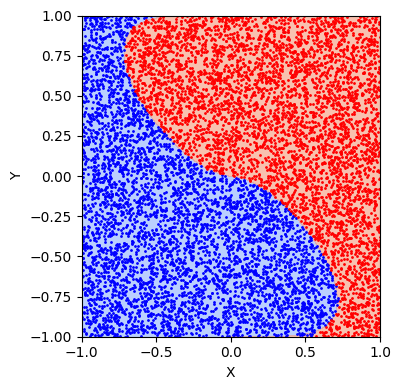

In [7]:
# Define the range of x and y values for the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Generate a grid of points
num_points = 1000
x_values = np.linspace(x_min, x_max, num_points)  
y_values = np.linspace(y_min, y_max, num_points)  
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Compute the decision boundary for the grid of points
for idx, data in enumerate( [ (X_test,outputs_test) ] ):

    plt.figure(figsize=(4, 4))

    b = 0 if idx == 0 else 0.15
    decision_boundary_grid = context_generator.decision_boundary_function(x_grid, y_grid, b)

    plt.contourf(x_grid, y_grid, decision_boundary_grid, levels=1, alpha=0.6, cmap=plt.cm.coolwarm)

    contexts = np.array( [ context_generator.denormalize(i) for i in data[0] ] ).squeeze(1)

    pred_action0 = [ i[0] if i[0] > 0.5 else np.nan for i in data[1]  ]
    indices_predaction0 = np.where(~np.isnan(pred_action0))[0]
    pred_action1 = [ i[0] if i[0] <= 0.5 else np.nan for i in data[1]  ]
    indices_predaction1 = np.where(~np.isnan(pred_action1))[0]

    plt.scatter(contexts[indices_predaction0][:,0], contexts[indices_predaction0][:,1], s = 1, color='blue', label='Predicted Points')
    plt.scatter(contexts[indices_predaction1][:,0], contexts[indices_predaction1][:,1], s = 1, color='red', label='Predicted Points')

    # Add labels and title to the plot
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.title(' Decision Boundary')
    # Adjust the layout for better spacing
    plt.tight_layout()
    plt.ylim((-1,1))
    plt.xlim((-1,1))

    # Save the figure to a file with tight layout and 380 DPI
    # plt.savefig('./figures/decision_boundary_{}.png'.format(idx), dpi=380, bbox_inches='tight')

In [8]:
outputs_test

tensor([[0.9988],
        [1.0034],
        [1.0007],
        ...,
        [0.0026],
        [1.0010],
        [1.0008]])

In [ ]:
for x,y in zip(X_test,outputs_test):
    